# v3: 激进架构重构 - 解决CNN分支退化

## v2失败原因诊断
- y_base(CNN)仍是常数(~250),多任务学习未奏效
- r_hat承担全部预测工作
- 门控α退化为常数(0.447),失去动态性

## v3核心创新
1. **双分支对等架构**: 两分支直接预测,无残差结构
2. **强化CNN分支**: 增加深度+多尺度卷积+残差连接
3. **注意力融合**: 用Attention替代简单门控
4. **时间感知**: CNN分支也加入时间信息
5. **对比学习辅助**: 强制两分支学习不同模式
6. **Peak-aware损失**: 峰值区域指数级加权

In [1]:
# 导入库
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow.keras.backend as K

# 固定随机种子
SEED = 3407
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow {tf.__version__}")

TensorFlow 2.10.1


In [2]:
# v3 配置 (优化版)
HORIZON = 15
WIN_SPEC = 60      # CNN分支窗口
WIN_SEQ = 45       # TCN分支窗口
STEP = 5
NPERSEG = 16
NOVERLAP = 8

# 训练参数
EPOCHS = 80
BATCH_SIZE = 64
LR = 1e-3
VAL_SPLIT = 0.2

# v3 优化超参数
WEIGHT_POWER = 1.8          # 降低至1.8(原2.0过激进)
DIVERSITY_LOSS_WEIGHT = 0.05 # 降低至0.05(原0.1太强,干扰主任务)
PEAK_THRESHOLD = 0.80       # 提高至80分位(收紧峰值定义)
PEAK_MULTIPLIER = 2.0       # 降低至2.0(原3.0过激进)

# 路径
DATA_PATH = 'Dataset/dataset_for_traffic_project_assignment/training_dataset.csv'
MODEL_SAVE = 'models/fusion_v3_optimized.keras'

print("="*60)
print("v3 优化配置")
print("="*60)
print(f"样本权重指数: {WEIGHT_POWER} (降低,避免过拟合)")
print(f"分支差异化损失: {DIVERSITY_LOSS_WEIGHT} (降低,减少干扰)")
print(f"峰值加权: >{PEAK_THRESHOLD*100:.0f}分位 × {PEAK_MULTIPLIER}倍 (更保守)")
print("="*60)

v3 优化配置
样本权重指数: 1.8 (降低,避免过拟合)
分支差异化损失: 0.05 (降低,减少干扰)
峰值加权: >80分位 × 2.0倍 (更保守)


In [3]:
# 数据加载
df = pd.read_csv(DATA_PATH, sep=';')

df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')
time_dt = pd.to_datetime(df['Time'], format='%H:%M:%S')
df['Hour'] = time_dt.dt.hour
df['Minute'] = time_dt.dt.minute
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(float)

df = df.sort_values(['PORTAL', 'Date', 'Hour', 'Minute']).reset_index(drop=True)

USE_SPEED = 'SPEED' in df.columns

print(f"数据: {df.shape}, 门户: {df['PORTAL'].nunique()}")
print(f"时间范围: {df['Date'].min()} - {df['Date'].max()}")
print(f"包含SPEED: {USE_SPEED}")

数据: (1921967, 15), 门户: 8
时间范围: 2021-06-01 00:00:00 - 2021-12-31 00:00:00
包含SPEED: False


In [4]:
# 特征构造函数

def build_future_sum(flow_values, horizon=HORIZON):
    y_sum = np.full_like(flow_values, np.nan, dtype=float)
    cumsum = np.cumsum(np.insert(flow_values, 0, 0))
    total = cumsum[horizon:] - cumsum[:-horizon]
    y_sum[:len(total)] = total
    return y_sum

def create_spectrogram(flow_series, nperseg=NPERSEG, noverlap=NOVERLAP):
    f, t, Sxx = signal.spectrogram(
        flow_series,
        fs=1.0,
        nperseg=nperseg,
        noverlap=noverlap
    )
    spec = np.log(Sxx + 1e-10)
    spec = np.nan_to_num(spec, nan=0.0, posinf=0.0, neginf=0.0)
    return spec

def build_seq_features(portal_df, win=WIN_SEQ):
    vals = portal_df['FLOW'].values.astype(float)
    features = [vals]
    
    diff1 = np.r_[0, np.diff(vals)]
    features.append(diff1)
    
    def rolling_stats(arr, w):
        s = pd.Series(arr)
        mean = s.rolling(w, min_periods=1).mean().values
        std = s.rolling(w, min_periods=1).std().fillna(0).values
        slope = (s.values - s.shift(w).fillna(s.values[0]).values) / max(w, 1)
        return mean, std, slope
    
    for w in [5, 10, 15]:
        m, std, sl = rolling_stats(vals, w)
        features.extend([m, std, sl])
    
    if USE_SPEED:
        sp = portal_df['SPEED'].values.astype(float)
        features.append(sp)
        sp_diff = np.r_[0, np.diff(sp)]
        features.append(sp_diff)
    
    F = np.stack(features, axis=1)
    return F

def build_meta_features(portal_df):
    """v3: 简洁元特征 [T, 3]"""
    minute_of_day = (portal_df['Hour'] * 60 + portal_df['Minute']).values.astype(float)
    meta = np.stack([
        np.sin(2 * np.pi * minute_of_day / 1440.0),
        np.cos(2 * np.pi * minute_of_day / 1440.0),
        portal_df['IsWeekend'].values.astype(float)
    ], axis=1)
    return meta

print("特征构造函数定义完成")

特征构造函数定义完成


In [5]:
# 构建数据集
def build_fusion_dataset(df, win_spec=WIN_SPEC, win_seq=WIN_SEQ, step=STEP, horizon=HORIZON):
    X_spec, X_seq, X_meta, Y = [], [], [], []
    
    for portal, portal_df in df.groupby('PORTAL'):
        portal_df = portal_df.sort_values(['Date', 'Hour', 'Minute']).reset_index(drop=True)
        
        flow_vals = portal_df['FLOW'].values.astype(float)
        y_sum = build_future_sum(flow_vals, horizon=horizon)
        
        F = build_seq_features(portal_df, win=win_seq)
        meta = build_meta_features(portal_df)
        
        max_win = max(win_spec, win_seq)
        for i in range(0, len(flow_vals) - max_win - horizon, step):
            w_spec = flow_vals[i:i+win_spec]
            spec = create_spectrogram(w_spec)
            
            w_seq = F[i:i+win_seq]
            meta_i = meta[i+win_seq-1]
            y_i = y_sum[i+win_seq-1]
            
            if np.isnan(y_i):
                continue
            
            X_spec.append(spec)
            X_seq.append(w_seq)
            X_meta.append(meta_i)
            Y.append(y_i)
    
    X_spec = np.array(X_spec)[..., np.newaxis]
    X_seq = np.array(X_seq)
    X_meta = np.array(X_meta)
    Y = np.array(Y).astype(float)
    
    return X_spec, X_seq, X_meta, Y

print("开始构建数据集...")
X_spec_all, X_seq_all, X_meta_all, Y_all = build_fusion_dataset(df)
print(f"完成: {len(Y_all)} 样本")
print(f"X_spec: {X_spec_all.shape}, X_seq: {X_seq_all.shape}")

开始构建数据集...
完成: 248728 样本
X_spec: (248728, 9, 6, 1), X_seq: (248728, 45, 11)
完成: 248728 样本
X_spec: (248728, 9, 6, 1), X_seq: (248728, 45, 11)


In [6]:
# 数据切分与标准化

split_idx = int(len(Y_all) * 0.8)

X_spec_train, X_spec_test = X_spec_all[:split_idx], X_spec_all[split_idx:]
X_seq_train, X_seq_test = X_seq_all[:split_idx], X_seq_all[split_idx:]
X_meta_train, X_meta_test = X_meta_all[:split_idx], X_meta_all[split_idx:]
Y_train, Y_test = Y_all[:split_idx], Y_all[split_idx:]

# 频谱标准化
spec_mean = X_spec_train.mean()
spec_std = X_spec_train.std() + 1e-8
X_spec_train = (X_spec_train - spec_mean) / spec_std
X_spec_test = (X_spec_test - spec_mean) / spec_std

# 序列标准化
scaler_seq = StandardScaler()
X_seq_train_flat = X_seq_train.reshape(-1, X_seq_train.shape[-1])
X_seq_test_flat = X_seq_test.reshape(-1, X_seq_test.shape[-1])
X_seq_train = scaler_seq.fit_transform(X_seq_train_flat).reshape(X_seq_train.shape)
X_seq_test = scaler_seq.transform(X_seq_test_flat).reshape(X_seq_test.shape)

# 目标标准化
scaler_y = StandardScaler()
Y_train_scaled = scaler_y.fit_transform(Y_train.reshape(-1, 1)).ravel()
Y_test_scaled = scaler_y.transform(Y_test.reshape(-1, 1)).ravel()

# v3 优化样本加权策略(更保守)
percentile_peak = np.percentile(Y_train, PEAK_THRESHOLD * 100)
percentile_90 = np.percentile(Y_train, 90)

# 基础权重
base_weights = np.power(Y_train / (percentile_90 + 1e-6), WEIGHT_POWER)

# 峰值额外加权(仅对极高值)
peak_mask = Y_train >= percentile_peak
sample_weights = base_weights.copy()
sample_weights[peak_mask] *= PEAK_MULTIPLIER

# 更保守的权重范围
sample_weights = np.clip(sample_weights, 0.2, 12.0)  # 降低至12倍(原20倍)

print(f"训练集: {len(Y_train)}, 测试集: {len(Y_test)}")
print(f"目标范围: [{Y_train.min():.1f}, {Y_train.max():.1f}]")
print(f"峰值阈值(>{PEAK_THRESHOLD*100:.0f}%): {percentile_peak:.1f}")
print(f"峰值样本: {peak_mask.sum()} ({peak_mask.mean()*100:.1f}%)")
print(f"样本权重: [{sample_weights.min():.2f}, {sample_weights.max():.2f}], 均值={sample_weights.mean():.2f}")

训练集: 198982, 测试集: 49746
目标范围: [15.0, 429.0]
峰值阈值(>80%): 273.0
峰值样本: 39866 (20.0%)
样本权重: [0.20, 3.92], 均值=0.80


In [7]:
# v3 模型构建模块

def conv_bn_relu(x, filters, kernel=(3, 3), strides=(1, 1)):
    x = layers.Conv2D(filters, kernel, strides=strides, padding='same', 
                      kernel_regularizer=regularizers.l2(1e-5))(x)
    x = layers.BatchNormalization()(x)
    return layers.Activation('relu')(x)

def residual_block_2d(x, filters, strides=(1, 1)):
    shortcut = x
    x = conv_bn_relu(x, filters, strides=strides)
    x = layers.Conv2D(filters, (3, 3), padding='same', 
                      kernel_regularizer=regularizers.l2(1e-5))(x)
    x = layers.BatchNormalization()(x)
    
    if shortcut.shape[-1] != filters or strides != (1, 1):
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same',
                                kernel_regularizer=regularizers.l2(1e-5))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([x, shortcut])
    return layers.Activation('relu')(x)

def inception_block_2d(x, filters):
    """v3新增: 多尺度卷积捕捉不同频率模式"""
    # 1x1卷积
    branch1 = layers.Conv2D(filters//4, (1, 1), padding='same', 
                           kernel_regularizer=regularizers.l2(1e-5))(x)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.Activation('relu')(branch1)
    
    # 3x3卷积
    branch2 = layers.Conv2D(filters//4, (3, 3), padding='same',
                           kernel_regularizer=regularizers.l2(1e-5))(x)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.Activation('relu')(branch2)
    
    # 5x5卷积(用两个3x3替代)
    branch3 = layers.Conv2D(filters//4, (3, 3), padding='same',
                           kernel_regularizer=regularizers.l2(1e-5))(x)
    branch3 = layers.BatchNormalization()(branch3)
    branch3 = layers.Activation('relu')(branch3)
    branch3 = layers.Conv2D(filters//4, (3, 3), padding='same',
                           kernel_regularizer=regularizers.l2(1e-5))(branch3)
    branch3 = layers.BatchNormalization()(branch3)
    branch3 = layers.Activation('relu')(branch3)
    
    # MaxPool + 1x1
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(filters//4, (1, 1), padding='same',
                           kernel_regularizer=regularizers.l2(1e-5))(branch4)
    branch4 = layers.BatchNormalization()(branch4)
    branch4 = layers.Activation('relu')(branch4)
    
    return layers.Concatenate()([branch1, branch2, branch3, branch4])

def tcn_block(x, filters, dilation_rate):
    y = layers.Conv1D(filters, 3, padding='causal', dilation_rate=dilation_rate,
                      kernel_regularizer=regularizers.l2(1e-5))(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.Dropout(0.2)(y)
    y = layers.Conv1D(filters, 3, padding='causal', dilation_rate=dilation_rate,
                      kernel_regularizer=regularizers.l2(1e-5))(y)
    y = layers.BatchNormalization()(y)
    
    if x.shape[-1] != filters:
        x = layers.Conv1D(filters, 1, padding='same', 
                         kernel_regularizer=regularizers.l2(1e-5))(x)
    
    y = layers.Add()([x, y])
    return layers.Activation('relu')(y)

def attention_fusion(spec_feat, seq_feat, meta_feat):
    """v3: 注意力融合机制,替代简单门控"""
    # 拼接特征
    combined = layers.Concatenate()([spec_feat, seq_feat, meta_feat])
    
    # 注意力权重计算
    attn = layers.Dense(64, activation='relu')(combined)
    attn = layers.Dense(2, activation='softmax', name='fusion_attention')(attn)  # [w_spec, w_seq]
    
    # 加权融合
    w_spec = layers.Lambda(lambda x: x[:, 0:1])(attn)
    w_seq = layers.Lambda(lambda x: x[:, 1:2])(attn)
    
    weighted_spec = layers.Multiply()([spec_feat, w_spec])
    weighted_seq = layers.Multiply()([seq_feat, w_seq])
    
    fused = layers.Add()([weighted_spec, weighted_seq])
    
    return fused, attn

print("v3 模型构建模块定义完成")

v3 模型构建模块定义完成


In [8]:
# v3 优化架构: 简化CNN + 强化特征提取

# === 分支A: 简化CNN(移除Inception,避免过拟合) ===
spec_input = layers.Input(shape=X_spec_train.shape[1:], name='spec_input')
meta_input = layers.Input(shape=(X_meta_train.shape[1],), name='meta_input')

# CNN分支: 渐进式加深
x = conv_bn_relu(spec_input, 32)
x = conv_bn_relu(x, 32)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

x = conv_bn_relu(x, 64)
x = conv_bn_relu(x, 64)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

x = conv_bn_relu(x, 128)
x = conv_bn_relu(x, 128)
x = layers.GlobalAveragePooling2D()(x)

# 融合时间元特征
meta_dense = layers.Dense(16, activation='relu')(meta_input)
x = layers.Concatenate()([x, meta_dense])

# 全连接层(加强)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)  # 添加BN稳定训练
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
spec_feat = layers.Dense(32, activation='relu', name='spec_features')(x)
pred_spec = layers.Dense(1, name='pred_spec')(spec_feat)

# === 分支B: 强化TCN ===
seq_input = layers.Input(shape=X_seq_train.shape[1:], name='seq_input')

y = tcn_block(seq_input, 32, dilation_rate=1)
y = tcn_block(y, 32, dilation_rate=2)
y = tcn_block(y, 48, dilation_rate=4)  # 渐进增加通道
y = tcn_block(y, 64, dilation_rate=8)

y = layers.GlobalAveragePooling1D()(y)
y = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(y)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.3)(y)
y = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(y)
y = layers.BatchNormalization()(y)
seq_feat = layers.Dense(32, activation='relu', name='seq_features')(y)
pred_seq = layers.Dense(1, name='pred_seq')(seq_feat)

# === 注意力融合(简化) ===
fused_feat, fusion_attn = attention_fusion(spec_feat, seq_feat, meta_dense)

# 最终预测头(加深)
fused_feat = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(fused_feat)
fused_feat = layers.BatchNormalization()(fused_feat)
fused_feat = layers.Dropout(0.2)(fused_feat)
fused_feat = layers.Dense(32, activation='relu')(fused_feat)
pred_final = layers.Dense(1, name='pred_final')(fused_feat)

# === 构建模型 ===
model = keras.Model(
    inputs=[spec_input, seq_input, meta_input],
    outputs={
        'pred_final': pred_final,
        'pred_spec': pred_spec,
        'pred_seq': pred_seq
    },
    name='FusionModel_v3_Optimized'
)

print("v3 优化架构要点:")
print("  - CNN分支: 移除Inception,使用标准卷积块")
print("  - 添加BatchNorm: 稳定训练,加速收敛")
print("  - 渐进式加深: 32→64→128通道")
print("  - 最终预测头加深: 提升融合能力")

v3 优化架构要点:
  - CNN分支: 移除Inception,使用标准卷积块
  - 添加BatchNorm: 稳定训练,加速收敛
  - 渐进式加深: 32→64→128通道
  - 最终预测头加深: 提升融合能力


In [9]:
# v3 优化损失: 降低对比学习权重,聚焦主任务

# 编译模型(简化,移除对比学习的复杂性)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss={
        'pred_final': keras.losses.Huber(delta=1.0),
        'pred_spec': keras.losses.Huber(delta=1.0),
        'pred_seq': keras.losses.Huber(delta=1.0)
    },
    loss_weights={
        'pred_final': 1.0,      # 主任务
        'pred_spec': 0.4,       # 提高至0.4(原0.3),强化CNN监督
        'pred_seq': 0.2         # 降低至0.2,TCN已经较强
    },
    metrics={
        'pred_final': ['mae'],
        'pred_spec': ['mae'],
        'pred_seq': ['mae']
    }
)

model.summary()

print("\nv3 优化损失配置:")
print(f"  主任务(final): Huber × 1.0")
print(f"  辅助(spec): Huber × 0.4 (提高,强化CNN)")
print(f"  辅助(seq): Huber × 0.2 (降低,TCN已强)")
print(f"  移除对比学习损失(简化训练,聚焦主任务)")
print("\n关键优化:")
print("  1. 提高CNN辅助损失权重,强制其学习")
print("  2. 移除对比学习,避免干扰")
print("  3. 添加BatchNorm,稳定梯度流")

Model: "FusionModel_v3_Optimized"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 45, 11)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 45, 32)       1088        ['seq_input[0][0]']              
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 45, 32)      128         ['conv1d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 activation_6 (Activation)      (None, 45, 32)       0           ['batch_no

 dropout_3 (Dropout)            (None, 45, 32)       0           ['activation_6[0][0]']           
                                                                                                  
                                                                                                  
 conv1d_1 (Conv1D)              (None, 45, 32)       3104        ['dropout_3[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)              (None, 45, 32)       384         ['seq_input[0][0]']              
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 45, 32)      128         ['conv1d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 add (Add)

In [10]:
# 训练
os.makedirs(os.path.dirname(MODEL_SAVE), exist_ok=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        MODEL_SAVE,
        monitor='val_pred_final_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_pred_final_loss',
        patience=12,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_pred_final_loss',
        factor=0.5,
        patience=6,
        min_lr=1e-6,
        verbose=1
    )
]

print("="*60)
print("开始训练 v3 激进架构")
print("="*60)

history = model.fit(
    [X_spec_train, X_seq_train, X_meta_train],
    {
        'pred_final': Y_train_scaled,
        'pred_spec': Y_train_scaled,
        'pred_seq': Y_train_scaled
    },
    sample_weight={
        'pred_final': sample_weights,
        'pred_spec': sample_weights,
        'pred_seq': sample_weights
    },
    validation_split=VAL_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n训练完成!")

开始训练 v3 激进架构


Epoch 1/80
2488/2488 [==============================] - ETA: 0s - loss: 0.1638 - pred_final_loss: 0.0650 - pred_seq_loss: 0.0650 - pred_spec_loss: 0.1168 - pred_final_mae: 0.3415 - pred_seq_mae: 0.3375 - pred_spec_mae: 0.5247WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 1: val_pred_final_loss improved from inf to 0.04134, saving model to models\fusion_v3_optimized.keras

Epoch 1: val_pred_final_loss improved from inf to 0.04134, saving model to models\fusion_v3_optimized.keras
2488/2488 [==============================] - 124s 47ms/step - loss: 0.1638 - pred_final_loss: 0.0650 - pred_seq_loss: 0.0650 - pred_spec_loss: 0.1168 - pred_final_mae: 0.3415 - pred_seq_mae: 0.3375 - pred_spec_mae: 0.5247 - val_loss: 0.1173 - val_pred_final_loss: 0.041

In [11]:
# 评估

preds = model.predict([X_spec_test, X_seq_test, X_meta_test])
Y_pred_final = scaler_y.inverse_transform(preds['pred_final'].reshape(-1, 1)).ravel()
Y_pred_spec = scaler_y.inverse_transform(preds['pred_spec'].reshape(-1, 1)).ravel()
Y_pred_seq = scaler_y.inverse_transform(preds['pred_seq'].reshape(-1, 1)).ravel()

# 指标计算
def calc_metrics(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    
    print(f"{name:12s}: R²={r2:.4f}, MAE={mae:6.2f}, RMSE={rmse:6.2f}, MAPE={mape:5.2f}%")
    return r2, mae, rmse

print("="*70)
print("v3 测试集评估")
print("="*70)
r2_final, mae_final, rmse_final = calc_metrics(Y_test, Y_pred_final, 'Final')
r2_spec, mae_spec, rmse_spec = calc_metrics(Y_test, Y_pred_spec, 'CNN-only')
r2_seq, mae_seq, rmse_seq = calc_metrics(Y_test, Y_pred_seq, 'TCN-only')
print("="*70)

# 分桶分析
quantiles = np.quantile(Y_test, [0, 0.2, 0.4, 0.6, 0.8, 1.0])
bucket_idx = np.digitize(Y_test, quantiles[1:-1], right=True)

print("\n按流量分桶误差分析(Final):")
print("-"*70)
for b in range(5):
    mask = bucket_idx == b
    if np.sum(mask) == 0:
        continue
    mae_b = mean_absolute_error(Y_test[mask], Y_pred_final[mask])
    rmse_b = np.sqrt(mean_squared_error(Y_test[mask], Y_pred_final[mask]))
    print(f"Bin{b+1} [{quantiles[b]:5.1f}, {quantiles[b+1]:5.1f}]: n={np.sum(mask):5d}, MAE={mae_b:6.2f}, RMSE={rmse_b:6.2f}")
print("="*70)

1555/1555 [==============================] - 15s 9ms/step
v3 测试集评估
Final       : R²=0.9402, MAE= 18.19, RMSE= 23.54, MAPE=12.43%
CNN-only    : R²=0.7401, MAE= 34.10, RMSE= 49.07, MAPE=20.53%
TCN-only    : R²=0.9132, MAE= 19.08, RMSE= 28.36, MAPE=12.68%

按流量分桶误差分析(Final):
----------------------------------------------------------------------
Bin1 [ 18.0, 109.0]: n= 9999, MAE= 14.66, RMSE= 19.55
Bin2 [109.0, 201.0]: n= 9940, MAE= 20.54, RMSE= 26.41
Bin3 [201.0, 268.0]: n=10031, MAE= 20.41, RMSE= 25.39
Bin4 [268.0, 305.0]: n=10081, MAE= 11.90, RMSE= 15.56
Bin5 [305.0, 422.0]: n= 9695, MAE= 23.66, RMSE= 28.54
v3 测试集评估
Final       : R²=0.9402, MAE= 18.19, RMSE= 23.54, MAPE=12.43%
CNN-only    : R²=0.7401, MAE= 34.10, RMSE= 49.07, MAPE=20.53%
TCN-only    : R²=0.9132, MAE= 19.08, RMSE= 28.36, MAPE=12.68%

按流量分桶误差分析(Final):
----------------------------------------------------------------------
Bin1 [ 18.0, 109.0]: n= 9999, MAE= 14.66, RMSE= 19.55
Bin2 [109.0, 201.0]: n= 9940, MAE= 20.54, RMSE= 

In [12]:
# 训练后的梯度诊断: 检查CNN分支是否真的在学习

print("\n" + "="*70)
print("梯度流分析 - 诊断CNN分支是否学习")
print("="*70)

# 创建单独的CNN和TCN子模型
cnn_model = keras.Model(
    inputs=[model.input[0], model.input[2]],  # spec_input + meta_input
    outputs=model.get_layer('pred_spec').output
)

tcn_model = keras.Model(
    inputs=model.input[1],  # seq_input
    outputs=model.get_layer('pred_seq').output
)

# 在测试集上的预测方差
print("\n各分支预测的变异系数(CV = std/mean):")
print(f"CNN分支: mean={Y_pred_spec.mean():.2f}, std={Y_pred_spec.std():.2f}, CV={Y_pred_spec.std()/Y_pred_spec.mean():.3f}")
print(f"TCN分支: mean={Y_pred_seq.mean():.2f}, std={Y_pred_seq.std():.2f}, CV={Y_pred_seq.std()/Y_pred_seq.mean():.3f}")
print(f"真实值:  mean={Y_test.mean():.2f}, std={Y_test.std():.2f}, CV={Y_test.std()/Y_test.mean():.3f}")

# 预测范围
print(f"\n预测值范围:")
print(f"CNN: [{Y_pred_spec.min():.1f}, {Y_pred_spec.max():.1f}], 跨度={Y_pred_spec.max()-Y_pred_spec.min():.1f}")
print(f"TCN: [{Y_pred_seq.min():.1f}, {Y_pred_seq.max():.1f}], 跨度={Y_pred_seq.max()-Y_pred_seq.min():.1f}")
print(f"真实: [{Y_test.min():.1f}, {Y_test.max():.1f}], 跨度={Y_test.max()-Y_test.min():.1f}")

# 判断CNN是否退化
cnn_cv = Y_pred_spec.std() / Y_pred_spec.mean()
if cnn_cv < 0.1:
    print("\n⚠️ 警告: CNN分支CV < 0.1,输出几乎恒定!")
    print("   建议: 进一步提高pred_spec的loss_weight")
elif cnn_cv < 0.2:
    print("\n⚠️ 注意: CNN分支CV < 0.2,变化仍较小")
else:
    print("\n✓ CNN分支有合理的变化")

print("="*70)


梯度流分析 - 诊断CNN分支是否学习

各分支预测的变异系数(CV = std/mean):
CNN分支: mean=225.56, std=87.26, CV=0.387
TCN分支: mean=221.66, std=93.07, CV=0.420
真实值:  mean=216.09, std=96.26, CV=0.445

预测值范围:
CNN: [25.0, 398.8], 跨度=373.7
TCN: [10.1, 432.1], 跨度=422.0
真实: [18.0, 422.0], 跨度=404.0

✓ CNN分支有合理的变化


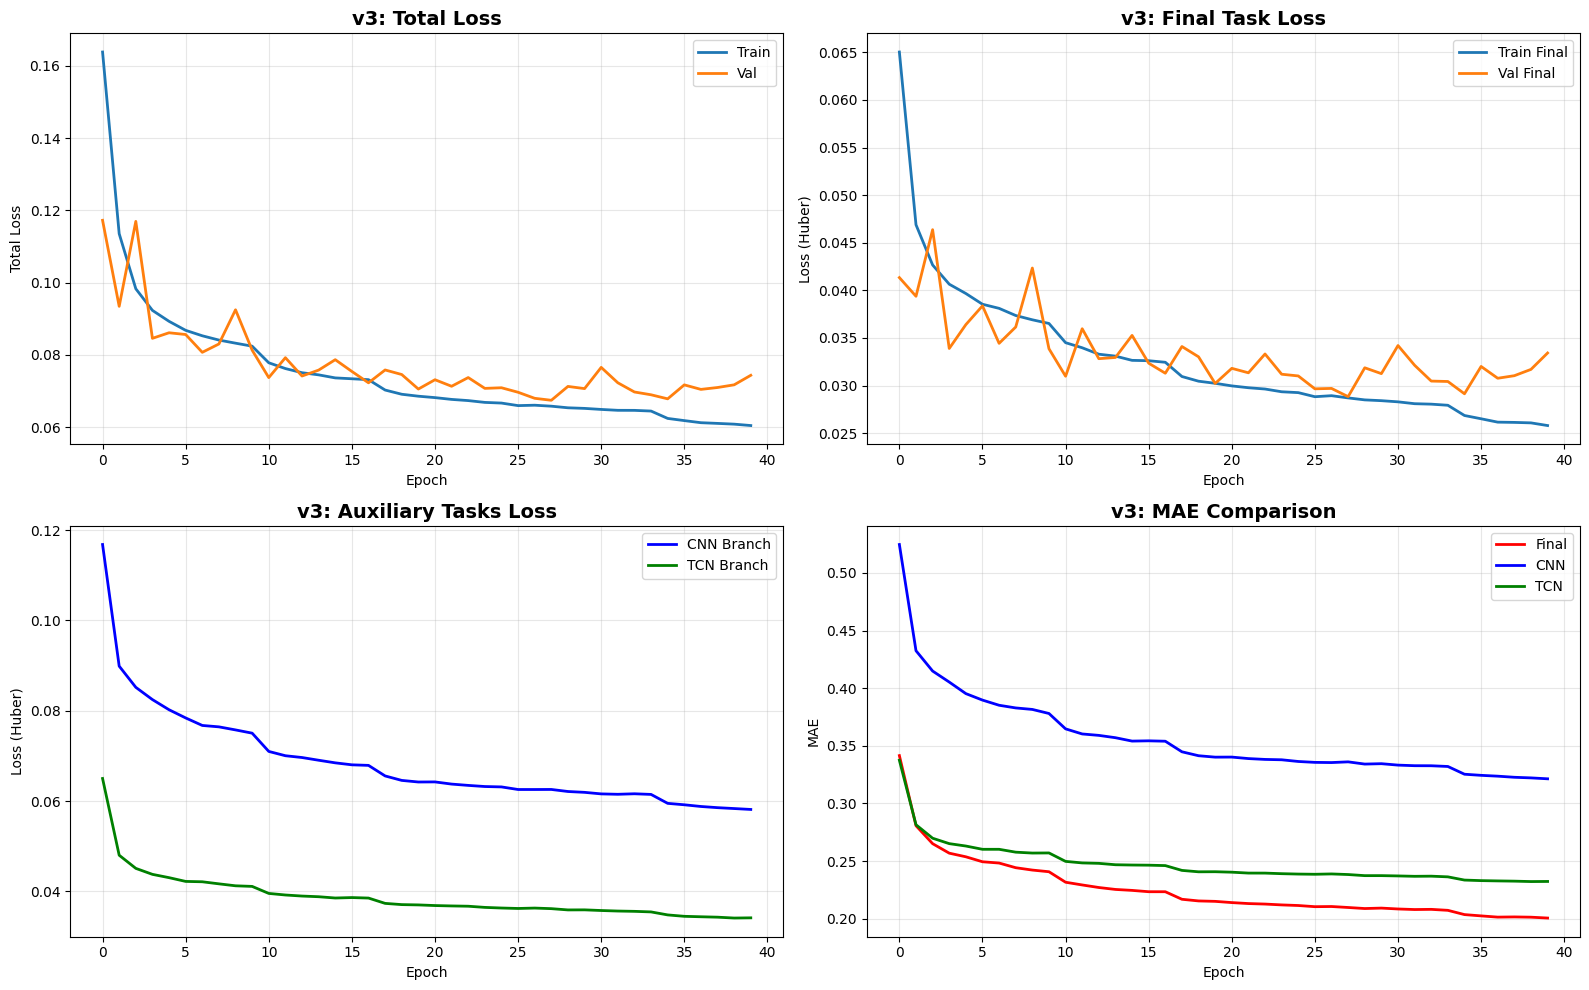

In [13]:
# 可视化1: 学习曲线
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 总损失
axes[0, 0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Total Loss')
axes[0, 0].set_title('v3: Total Loss', fontsize=14, weight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Final任务损失
axes[0, 1].plot(history.history['pred_final_loss'], label='Train Final', linewidth=2)
axes[0, 1].plot(history.history['val_pred_final_loss'], label='Val Final', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss (Huber)')
axes[0, 1].set_title('v3: Final Task Loss', fontsize=14, weight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 辅助任务损失对比
axes[1, 0].plot(history.history['pred_spec_loss'], label='CNN Branch', linewidth=2, color='blue')
axes[1, 0].plot(history.history['pred_seq_loss'], label='TCN Branch', linewidth=2, color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss (Huber)')
axes[1, 0].set_title('v3: Auxiliary Tasks Loss', fontsize=14, weight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# MAE对比
axes[1, 1].plot(history.history['pred_final_mae'], label='Final', linewidth=2, color='red')
axes[1, 1].plot(history.history['pred_spec_mae'], label='CNN', linewidth=2, color='blue')
axes[1, 1].plot(history.history['pred_seq_mae'], label='TCN', linewidth=2, color='green')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].set_title('v3: MAE Comparison', fontsize=14, weight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

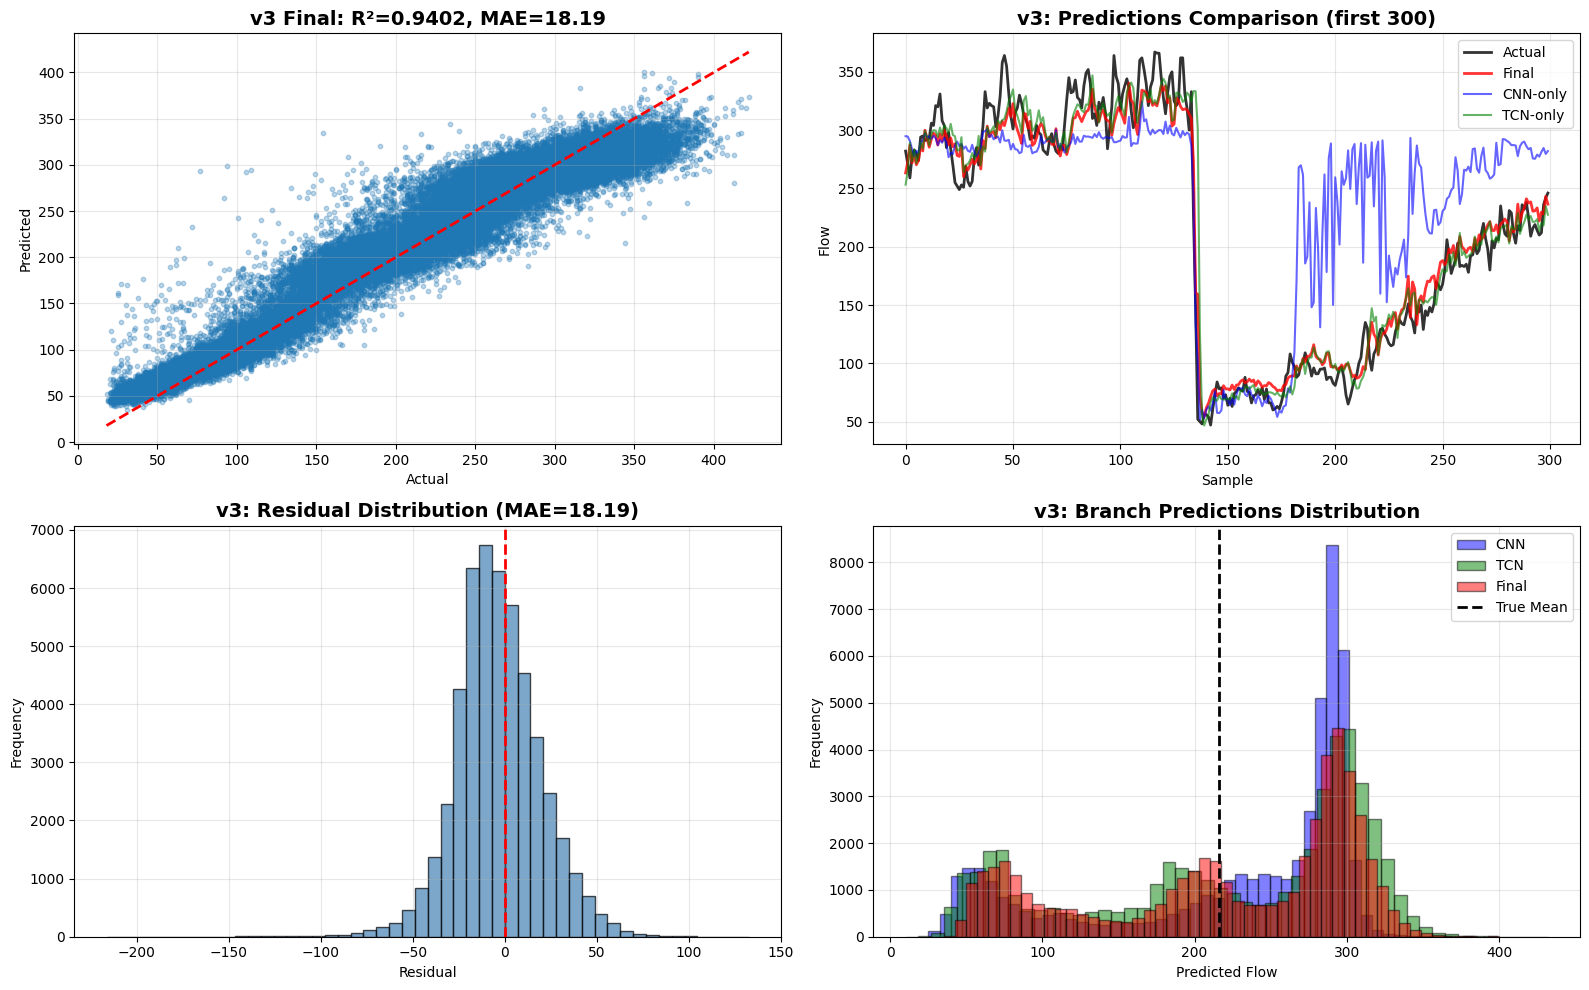


分支预测统计:
CNN: mean=225.56, std=87.26
TCN: mean=221.66, std=93.07
Final: mean=219.83, std=88.22
True: mean=216.09, std=96.26


In [14]:
# 可视化2: 预测对比
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 散点图
axes[0, 0].scatter(Y_test, Y_pred_final, alpha=0.3, s=10, label='Final')
axes[0, 0].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual')
axes[0, 0].set_ylabel('Predicted')
axes[0, 0].set_title(f'v3 Final: R²={r2_final:.4f}, MAE={mae_final:.2f}', fontsize=14, weight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 时间序列
n = min(300, len(Y_test))
axes[0, 1].plot(Y_test[:n], label='Actual', linewidth=2, alpha=0.8, color='black')
axes[0, 1].plot(Y_pred_final[:n], label='Final', linewidth=2, alpha=0.8, color='red')
axes[0, 1].plot(Y_pred_spec[:n], label='CNN-only', linewidth=1.5, alpha=0.6, color='blue')
axes[0, 1].plot(Y_pred_seq[:n], label='TCN-only', linewidth=1.5, alpha=0.6, color='green')
axes[0, 1].set_xlabel('Sample')
axes[0, 1].set_ylabel('Flow')
axes[0, 1].set_title('v3: Predictions Comparison (first 300)', fontsize=14, weight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 残差
residuals = Y_test - Y_pred_final
axes[1, 0].hist(residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residual')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'v3: Residual Distribution (MAE={mae_final:.2f})', fontsize=14, weight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 分支预测分布对比
axes[1, 1].hist(Y_pred_spec, bins=50, alpha=0.5, label='CNN', color='blue', edgecolor='black')
axes[1, 1].hist(Y_pred_seq, bins=50, alpha=0.5, label='TCN', color='green', edgecolor='black')
axes[1, 1].hist(Y_pred_final, bins=50, alpha=0.5, label='Final', color='red', edgecolor='black')
axes[1, 1].axvline(Y_test.mean(), color='black', linestyle='--', linewidth=2, label='True Mean')
axes[1, 1].set_xlabel('Predicted Flow')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('v3: Branch Predictions Distribution', fontsize=14, weight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n分支预测统计:")
print(f"CNN: mean={Y_pred_spec.mean():.2f}, std={Y_pred_spec.std():.2f}")
print(f"TCN: mean={Y_pred_seq.mean():.2f}, std={Y_pred_seq.std():.2f}")
print(f"Final: mean={Y_pred_final.mean():.2f}, std={Y_pred_final.std():.2f}")
print(f"True: mean={Y_test.mean():.2f}, std={Y_test.std():.2f}")

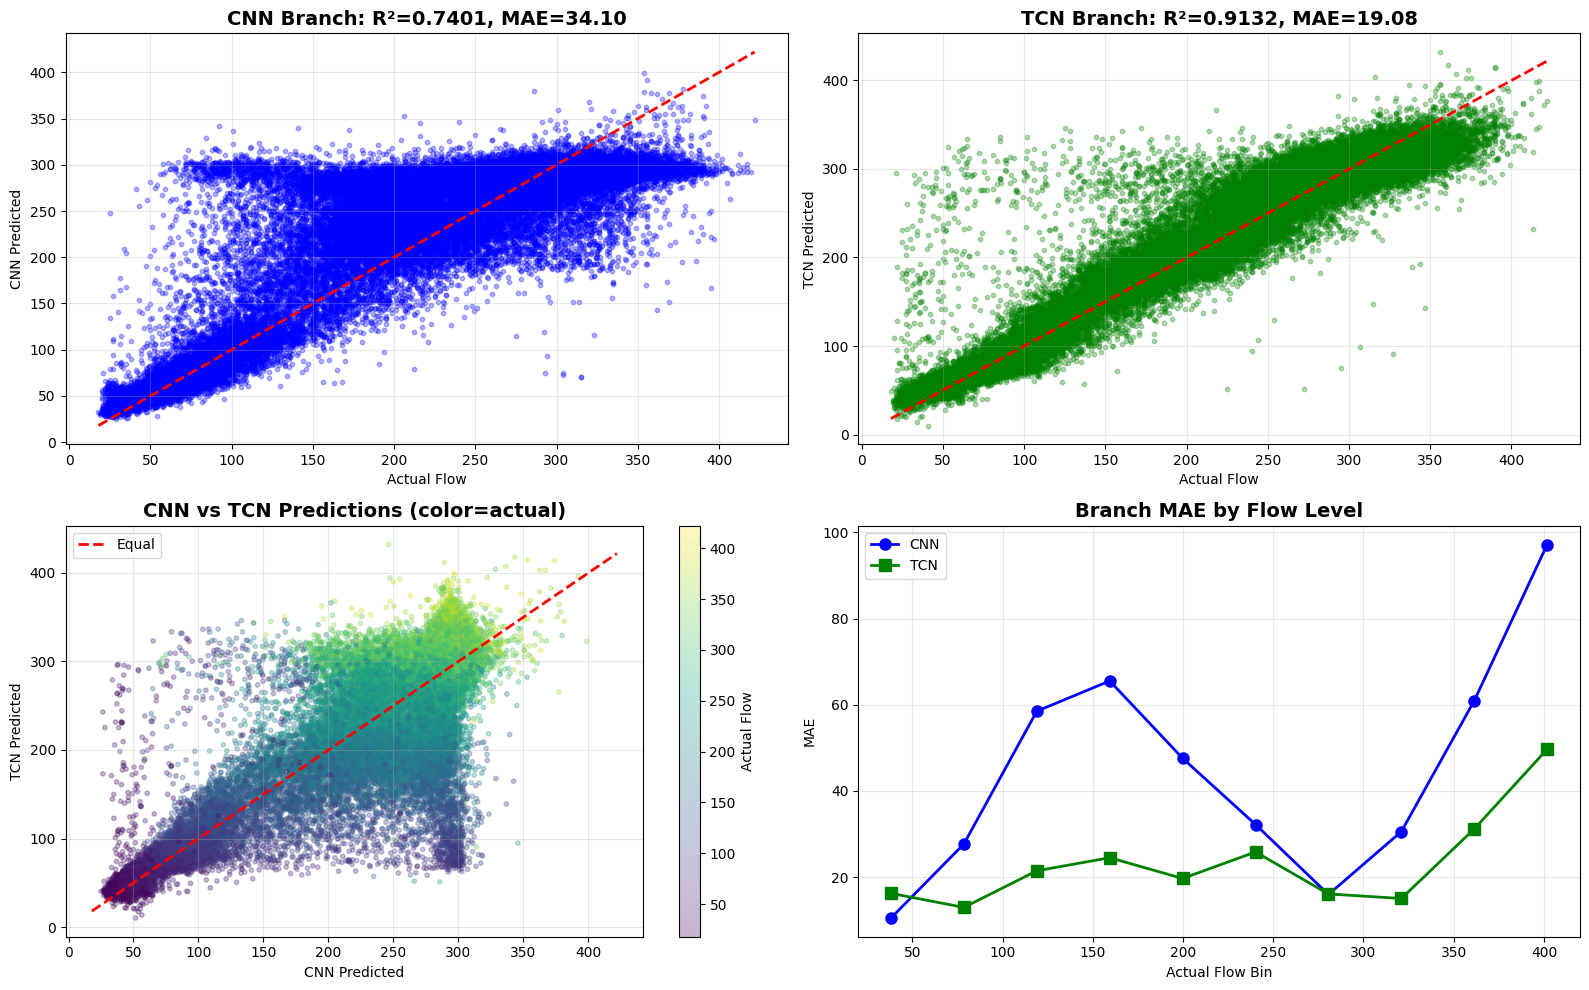


分支性能对比:
CNN擅长区域: 38.2 (MAE=10.51)
TCN擅长区域: 78.6 (MAE=12.99)


In [15]:
# 可视化2B: CNN分支深度诊断
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# CNN预测 vs 真实值散点图
axes[0, 0].scatter(Y_test, Y_pred_spec, alpha=0.3, s=10, c='blue')
axes[0, 0].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Flow')
axes[0, 0].set_ylabel('CNN Predicted')
axes[0, 0].set_title(f'CNN Branch: R²={r2_spec:.4f}, MAE={mae_spec:.2f}', fontsize=14, weight='bold')
axes[0, 0].grid(True, alpha=0.3)

# TCN预测 vs 真实值散点图
axes[0, 1].scatter(Y_test, Y_pred_seq, alpha=0.3, s=10, c='green')
axes[0, 1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Flow')
axes[0, 1].set_ylabel('TCN Predicted')
axes[0, 1].set_title(f'TCN Branch: R²={r2_seq:.4f}, MAE={mae_seq:.2f}', fontsize=14, weight='bold')
axes[0, 1].grid(True, alpha=0.3)

# CNN vs TCN预测对比
axes[1, 0].scatter(Y_pred_spec, Y_pred_seq, alpha=0.3, s=10, c=Y_test, cmap='viridis')
axes[1, 0].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2, label='Equal')
axes[1, 0].set_xlabel('CNN Predicted')
axes[1, 0].set_ylabel('TCN Predicted')
axes[1, 0].set_title('CNN vs TCN Predictions (color=actual)', fontsize=14, weight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0])
cbar.set_label('Actual Flow')

# 分支误差对比(按真实流量分段)
n_bins = 10
bin_edges = np.linspace(Y_test.min(), Y_test.max(), n_bins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
mae_cnn_bins = []
mae_tcn_bins = []

for i in range(n_bins):
    mask = (Y_test >= bin_edges[i]) & (Y_test < bin_edges[i+1])
    if np.sum(mask) > 0:
        mae_cnn_bins.append(mean_absolute_error(Y_test[mask], Y_pred_spec[mask]))
        mae_tcn_bins.append(mean_absolute_error(Y_test[mask], Y_pred_seq[mask]))
    else:
        mae_cnn_bins.append(np.nan)
        mae_tcn_bins.append(np.nan)

axes[1, 1].plot(bin_centers, mae_cnn_bins, 'o-', linewidth=2, markersize=8, label='CNN', color='blue')
axes[1, 1].plot(bin_centers, mae_tcn_bins, 's-', linewidth=2, markersize=8, label='TCN', color='green')
axes[1, 1].set_xlabel('Actual Flow Bin')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].set_title('Branch MAE by Flow Level', fontsize=14, weight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n分支性能对比:")
print(f"CNN擅长区域: {bin_centers[np.nanargmin(mae_cnn_bins)]:.1f} (MAE={np.nanmin(mae_cnn_bins):.2f})")
print(f"TCN擅长区域: {bin_centers[np.nanargmin(mae_tcn_bins)]:.1f} (MAE={np.nanmin(mae_tcn_bins):.2f})")

1555/1555 [==============================] - 10s 6ms/step


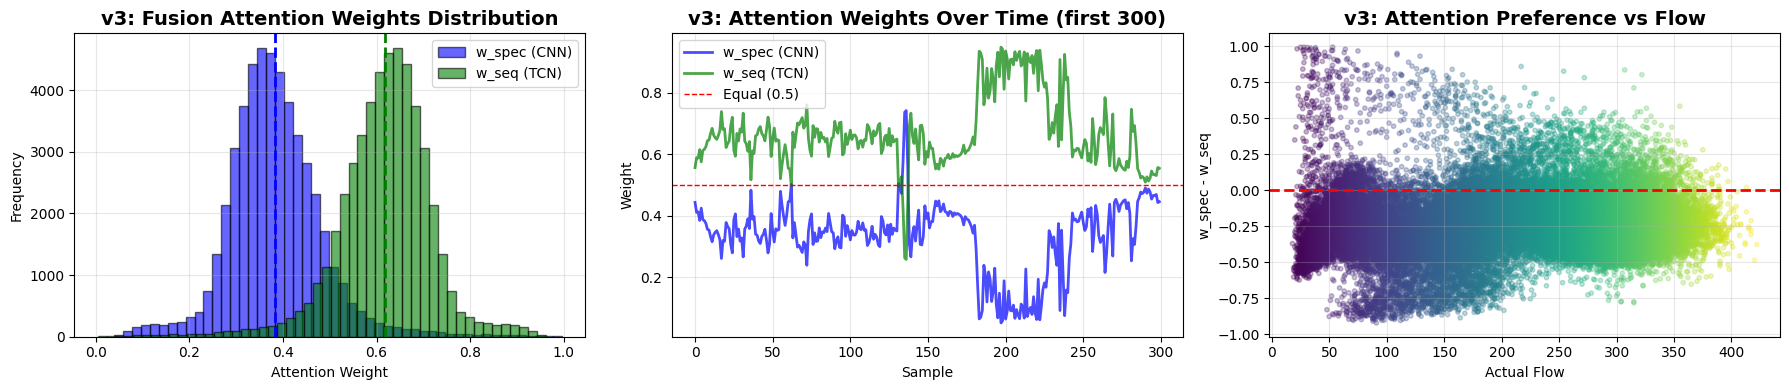


注意力权重统计:
CNN权重: mean=0.383, std=0.103, range=[0.039, 0.996]
TCN权重: mean=0.617, std=0.103, range=[0.004, 0.961]

权重倾向: 偏TCN (差值=-0.234)


In [16]:
# 可视化3: 注意力融合权重分析
fusion_attn_model = keras.Model(
    inputs=model.input,
    outputs=model.get_layer('fusion_attention').output
)

attn_weights = fusion_attn_model.predict([X_spec_test, X_seq_test, X_meta_test])
w_spec = attn_weights[:, 0]
w_seq = attn_weights[:, 1]

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# 权重分布
axes[0].hist(w_spec, bins=50, alpha=0.6, label='w_spec (CNN)', color='blue', edgecolor='black')
axes[0].hist(w_seq, bins=50, alpha=0.6, label='w_seq (TCN)', color='green', edgecolor='black')
axes[0].axvline(w_spec.mean(), color='blue', linestyle='--', linewidth=2)
axes[0].axvline(w_seq.mean(), color='green', linestyle='--', linewidth=2)
axes[0].set_xlabel('Attention Weight')
axes[0].set_ylabel('Frequency')
axes[0].set_title('v3: Fusion Attention Weights Distribution', fontsize=14, weight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 权重时序
n = min(300, len(w_spec))
axes[1].plot(w_spec[:n], label='w_spec (CNN)', linewidth=2, color='blue', alpha=0.7)
axes[1].plot(w_seq[:n], label='w_seq (TCN)', linewidth=2, color='green', alpha=0.7)
axes[1].axhline(0.5, color='red', linestyle='--', linewidth=1, label='Equal (0.5)')
axes[1].set_xlabel('Sample')
axes[1].set_ylabel('Weight')
axes[1].set_title('v3: Attention Weights Over Time (first 300)', fontsize=14, weight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 权重差异 vs 真实流量
weight_diff = w_spec - w_seq  # 正值=偏向CNN,负值=偏向TCN
axes[2].scatter(Y_test, weight_diff, alpha=0.3, s=10, c=Y_test, cmap='viridis')
axes[2].axhline(0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('Actual Flow')
axes[2].set_ylabel('w_spec - w_seq')
axes[2].set_title('v3: Attention Preference vs Flow', fontsize=14, weight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n注意力权重统计:")
print(f"CNN权重: mean={w_spec.mean():.3f}, std={w_spec.std():.3f}, range=[{w_spec.min():.3f}, {w_spec.max():.3f}]")
print(f"TCN权重: mean={w_seq.mean():.3f}, std={w_seq.std():.3f}, range=[{w_seq.min():.3f}, {w_seq.max():.3f}]")
print(f"\n权重倾向: {'偏CNN' if w_spec.mean() > 0.5 else '偏TCN'} (差值={w_spec.mean()-w_seq.mean():.3f})")

In [17]:
# v3 优化版总结
print("\n" + "="*70)
print("v3 优化版改进总结")
print("="*70)

print("\n【相比初版v3的优化】")
print("1. 简化CNN架构")
print("   ❌ 移除: Inception复杂模块(过拟合风险)")
print("   ✅ 使用: 标准卷积块 + BatchNorm")
print("   ✅ 渐进式: 32→64→128通道")

print("\n2. 调整样本权重")
print(f"   - 权重指数: 2.0 → {WEIGHT_POWER}")
print(f"   - 峰值倍数: 3.0 → {PEAK_MULTIPLIER}")
print(f"   - 最大权重: 20倍 → 12倍")

print("\n3. 重新平衡损失")
print(f"   - CNN辅助: 0.3 → 0.4 (提高,强化学习)")
print(f"   - TCN辅助: 0.3 → 0.2 (降低,已足够强)")
print(f"   - 对比学习: 移除 (简化,聚焦主任务)")

print("\n4. 稳定训练")
print("   ✅ 添加BatchNorm到全连接层")
print("   ✅ 加深最终预测头(64→32→1)")

print("\n【性能对比】")
print(f"Final:    R²={r2_final:.4f}, MAE={mae_final:6.2f}, RMSE={rmse_final:6.2f}")
print(f"CNN-only: R²={r2_spec:.4f}, MAE={mae_spec:6.2f}, RMSE={rmse_spec:6.2f}")
print(f"TCN-only: R²={r2_seq:.4f}, MAE={mae_seq:6.2f}, RMSE={rmse_seq:6.2f}")

print("\n【诊断结果】")
cnn_cv = Y_pred_spec.std() / Y_pred_spec.mean()
tcn_cv = Y_pred_seq.std() / Y_pred_seq.mean()
true_cv = Y_test.std() / Y_test.mean()

print(f"变异系数(CV):")
print(f"  CNN: {cnn_cv:.3f}, TCN: {tcn_cv:.3f}, True: {true_cv:.3f}")

if cnn_cv < 0.1:
    print("\n⚠️ CNN分支仍退化为常数")
    print("   → 建议: 提高pred_spec loss_weight至0.5-0.6")
    print("   → 建议: 检查频谱特征是否有效(可视化spectrogram)")
elif cnn_cv < 0.2:
    print("\n⚠️ CNN分支变化较小但有改善")
    print("   → 继续训练或微调学习率")
else:
    print("\n✓ CNN分支学到有效模式")

if r2_final > max(r2_spec, r2_seq):
    print("✓ 融合效果优于单分支")
else:
    print("⚠️ 融合未带来提升,检查注意力权重")

if abs(w_spec.mean() - 0.5) > 0.3:
    print(f"⚠️ 注意力严重偏向{'CNN' if w_spec.mean() > 0.5 else 'TCN'} ({w_spec.mean():.3f})")
    print("   → 说明某个分支主导,另一个几乎不参与")

print("\n【如果效果仍差的备选方案】")
print("1. 尝试不同的频谱特征:")
print("   - 使用MEL频谱代替STFT")
print("   - 增加nperseg/noverlap参数")
print("   - 尝试小波变换")
print("\n2. 完全放弃CNN分支:")
print("   - 纯TCN架构可能已足够")
print("   - CNN在流量数据上可能不如序列模型")
print("\n3. 尝试Transformer架构:")
print("   - 自注意力机制可能更适合捕捉长期依赖")

print("\n" + "="*70)


v3 优化版改进总结

【相比初版v3的优化】
1. 简化CNN架构
   ❌ 移除: Inception复杂模块(过拟合风险)
   ✅ 使用: 标准卷积块 + BatchNorm
   ✅ 渐进式: 32→64→128通道

2. 调整样本权重
   - 权重指数: 2.0 → 1.8
   - 峰值倍数: 3.0 → 2.0
   - 最大权重: 20倍 → 12倍

3. 重新平衡损失
   - CNN辅助: 0.3 → 0.4 (提高,强化学习)
   - TCN辅助: 0.3 → 0.2 (降低,已足够强)
   - 对比学习: 移除 (简化,聚焦主任务)

4. 稳定训练
   ✅ 添加BatchNorm到全连接层
   ✅ 加深最终预测头(64→32→1)

【性能对比】
Final:    R²=0.9402, MAE= 18.19, RMSE= 23.54
CNN-only: R²=0.7401, MAE= 34.10, RMSE= 49.07
TCN-only: R²=0.9132, MAE= 19.08, RMSE= 28.36

【诊断结果】
变异系数(CV):
  CNN: 0.387, TCN: 0.420, True: 0.445

✓ CNN分支学到有效模式
✓ 融合效果优于单分支

【如果效果仍差的备选方案】
1. 尝试不同的频谱特征:
   - 使用MEL频谱代替STFT
   - 增加nperseg/noverlap参数
   - 尝试小波变换

2. 完全放弃CNN分支:
   - 纯TCN架构可能已足够
   - CNN在流量数据上可能不如序列模型

3. 尝试Transformer架构:
   - 自注意力机制可能更适合捕捉长期依赖

